<h1><center><font size="6">iWildCam 2019 EDA</font></center></h1>

<center><img src="https://upload.wikimedia.org/wikipedia/commons/0/01/Fauna.jpg" width="800"></img></center>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
- <a href='#4'>Model</a>   
- <a href='#5'>References</a>

# <a id='1'>Introduction</a>  

## Competition

Biologists all over the world use camera traps to monitor biodiversity and population density of animal species. They have recently been making strides towards automating the species classification challenge in camera traps, but as they try to expand the scope of these models from specific regions where they have collected training data to nearby areas we are faced with an interesting probem: how do you classify a species in a new region that you may not have seen in previous training data?

## Data

In order to tackle this problem, the competition organizers have prepared a challenge where the training data and test data are from different regions, namely The American Southwest and the American Northwest. The species seen in each region overlap, but are not identical, and the challenge is to classify the test species correctly.  

## Kernel

In this Kernel we perform EDA on the data and create a predictive model, using <a href='#5'>References</a> [5]-[9].  The predictive model solution, including the use of pretrained DenseNet weights and reduced image sizes, should be credited to [5].

## References

Please consult the <a href='#5'>References</a> section for the datasets, Kernels and articles used in this Kernel.

# <a id='2'>Prepare for data analysis</a>  


## Load packages

In [1]:
import gc
import os
import json
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Load data   

Let's check what data files are available.

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/iwildcam/"
else:
    PATH="../input/iwildcam-2019-fgvc6/"
os.listdir(PATH)

['test.csv',
 'test_images',
 'train.csv',
 'sample_submission.csv',
 'train_images']

In [3]:
%%time
train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(PATH, 'test.csv'))

CPU times: user 1.17 s, sys: 156 ms, total: 1.33 s
Wall time: 1.34 s


In [4]:
x_train = np.load('../input/reducing-image-sizes-to-32x32/X_train.npy')
x_test = np.load('../input/reducing-image-sizes-to-32x32/X_test.npy')
y_train = np.load('../input/reducing-image-sizes-to-32x32/y_train.npy')

Let's check the files.

In [5]:
train_df.head()

category_id        date_captured   ...   width  height
0           19  2011-05-13 23:43:18   ...    1024     747
1           19  2012-03-17 03:48:44   ...    1024     747
2            0  2014-05-11 11:56:46   ...    1024     747
3            0  2013-10-06 02:00:00   ...    1024     747
4            0  2011-07-12 13:11:16   ...    1024     747

[5 rows x 11 columns]

In [6]:
test_df.head()

date_captured  ...   height
0  2016-01-03 11:30:56  ...      726
1  2016-01-03 11:30:57  ...      726
2  2016-01-03 11:30:58  ...      726
3  2016-01-03 11:30:59  ...      726
4  2016-01-03 11:31:00  ...      726

[5 rows x 10 columns]

In [7]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (196299, 11) (153730, 10)


# <a id='3'>Data exploration</a>  

Let's define the classes:

In [8]:
classes_wild = {0: 'empty', 1: 'deer', 2: 'moose', 3: 'squirrel', 4: 'rodent', 5: 'small_mammal', \
                6: 'elk', 7: 'pronghorn_antelope', 8: 'rabbit', 9: 'bighorn_sheep', 10: 'fox', 11: 'coyote', \
                12: 'black_bear', 13: 'raccoon', 14: 'skunk', 15: 'wolf', 16: 'bobcat', 17: 'cat',\
                18: 'dog', 19: 'opossum', 20: 'bison', 21: 'mountain_goat', 22: 'mountain_lion'}

In [9]:
train_df['classes_wild'] = train_df['category_id'].apply(lambda cw: classes_wild[cw])

We check again train:

In [10]:
train_df.head()

category_id        date_captured      ...      height  classes_wild
0           19  2011-05-13 23:43:18      ...         747       opossum
1           19  2012-03-17 03:48:44      ...         747       opossum
2            0  2014-05-11 11:56:46      ...         747         empty
3            0  2013-10-06 02:00:00      ...         747         empty
4            0  2011-07-12 13:11:16      ...         747         empty

[5 rows x 12 columns]

## Check images  
Let's check how many images are in train and test images folders.

In [11]:
train_image_files = list(os.listdir(os.path.join(PATH,'train_images')))
test_image_files = list(os.listdir(os.path.join(PATH,'test_images')))
                         
print("Number of image files: train:{} test:{}".format(len(train_image_files), len(test_image_files)))

Number of image files: train:196086 test:153730


We can observe that the number of images in train folder is smaller that the number of rows in train dataset while the number of images in test folder is equal with the number of rows in test dataset.

Let's check if every row in train and test have a corresponding image in the images folders.

In [12]:
%%time
train_file_names = list(train_df['file_name'])
print("Matching train image names: {}".format(len(set(train_file_names).intersection(train_image_files))))

Matching train image names: 196086
CPU times: user 104 ms, sys: 12 ms, total: 116 ms
Wall time: 114 ms


In [13]:
%%time
test_file_names = list(test_df['file_name'])
print("Matching test image names: {}".format(len(set(test_file_names).intersection(test_image_files))))

Matching test image names: 153730
CPU times: user 56 ms, sys: 4 ms, total: 60 ms
Wall time: 59.8 ms


## Clases of images

Let's check the classes of images in train_df.

In [14]:
cnt_classes_images = train_df.classes_wild.nunique()
print("There are {} classes of images".format(cnt_classes_images))
pd.DataFrame(train_df.classes_wild.value_counts()).transpose()

There are 14 classes of images


empty  opossum      ...         fox  mountain_lion
classes_wild  131457    14106      ...        1093             33

[1 rows x 14 columns]

In [15]:
def plot_classes(feature, fs=8, show_percents=True, color_palette='Set3'):
    f, ax = plt.subplots(1,1, figsize=(2*fs,4))
    total = float(len(train_df))
    g = sns.countplot(train_df[feature], order = train_df[feature].value_counts().index, palette=color_palette)
    g.set_title("Number and percentage of labels for each class of {}".format(feature))
    if(show_percents):
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(100*height/total),
                    ha="center") 
    plt.show()    

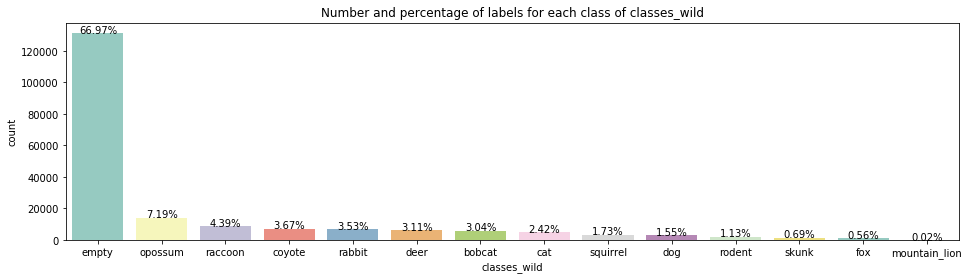

In [16]:
plot_classes('classes_wild')

Most of the images are of classe `empty`, followed by `opossum`, `racoon`, `coyote` and `rabbit`.

## Number of sequences frames

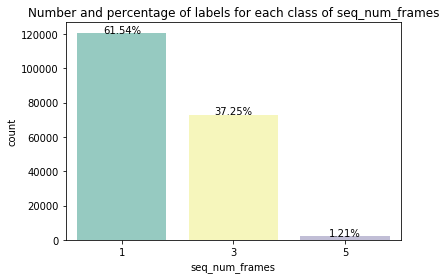

In [17]:
plot_classes('seq_num_frames', fs=3)

Majority of sequence number frames are 1 (61%), followed by 3 (37%), the rest (1.2%) having 5.

## Locations distribution

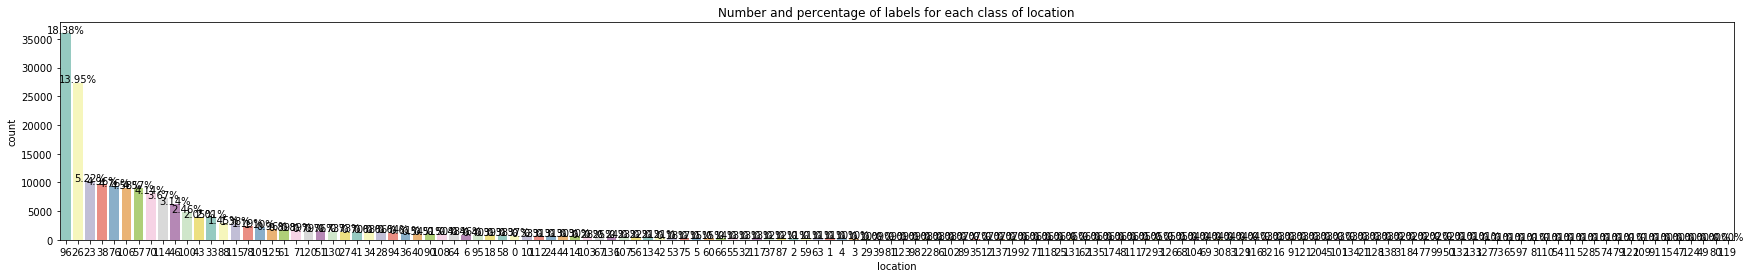

In [18]:
plot_classes('location', fs=15)

Majority of images are from location 96 (18.38%) and 26 (13.95%).

## Locations and classes

Let's show now the locations and classes.

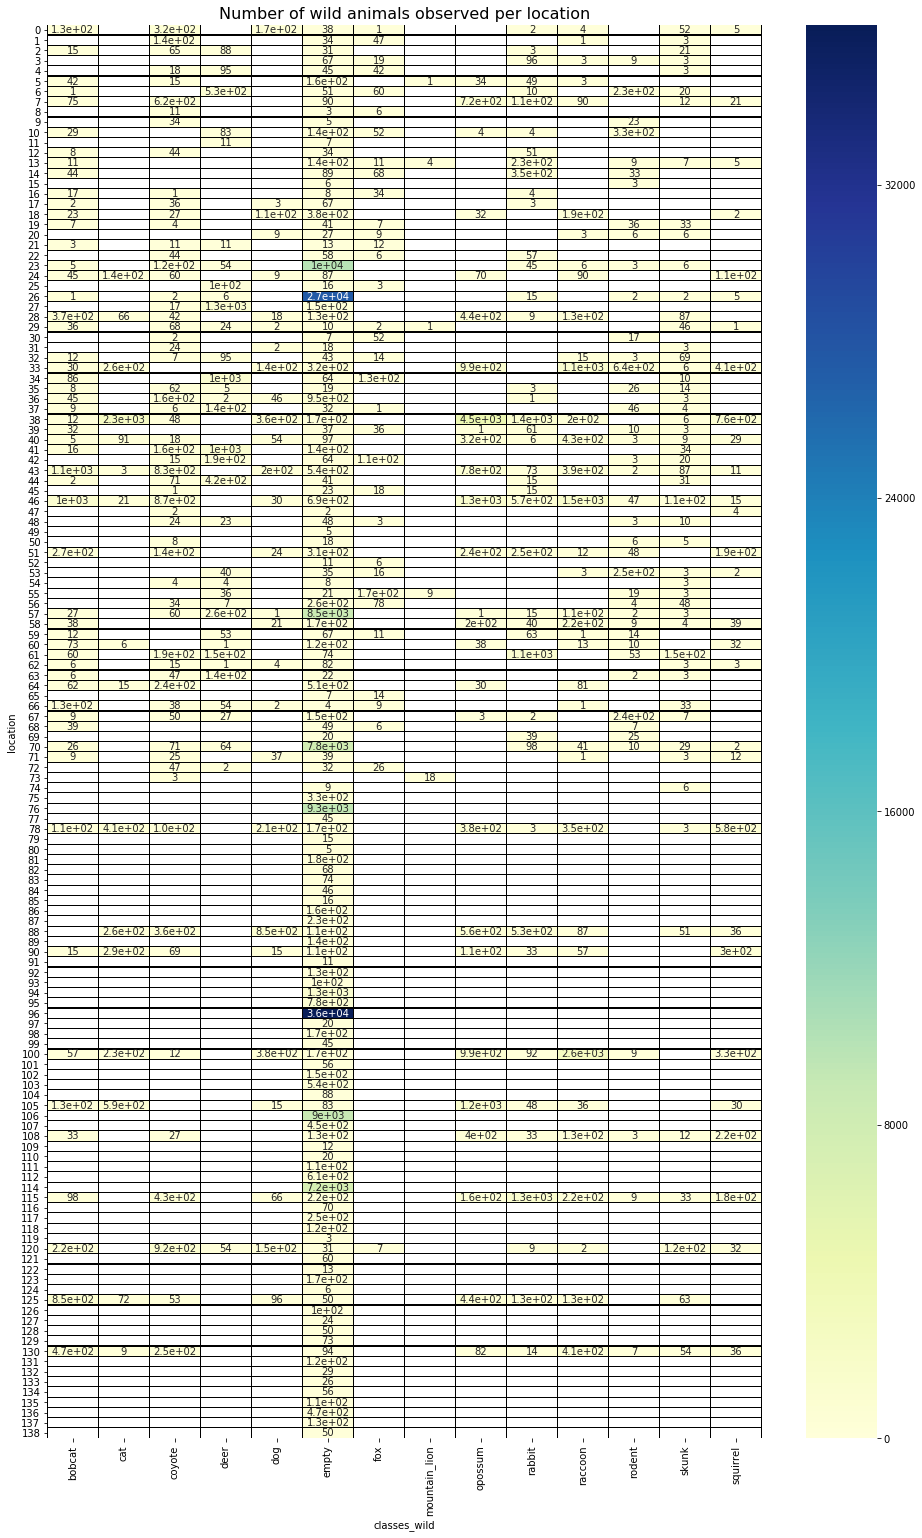

In [19]:
fig, ax = plt.subplots(1,1,figsize=(16,26))
t = pd.DataFrame(train_df.groupby(['classes_wild', 'location'])['seq_id'].count().reset_index())
m = t.pivot(index='location', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per location', size=16)
plt.show()

Majority of records are actually from location 96 and without specifying the wild animal class (`empty`). Also, location 26 (the next one as frequence) is as well for `empty` class. Let's see what we get if we just remove the entries with `empty`.


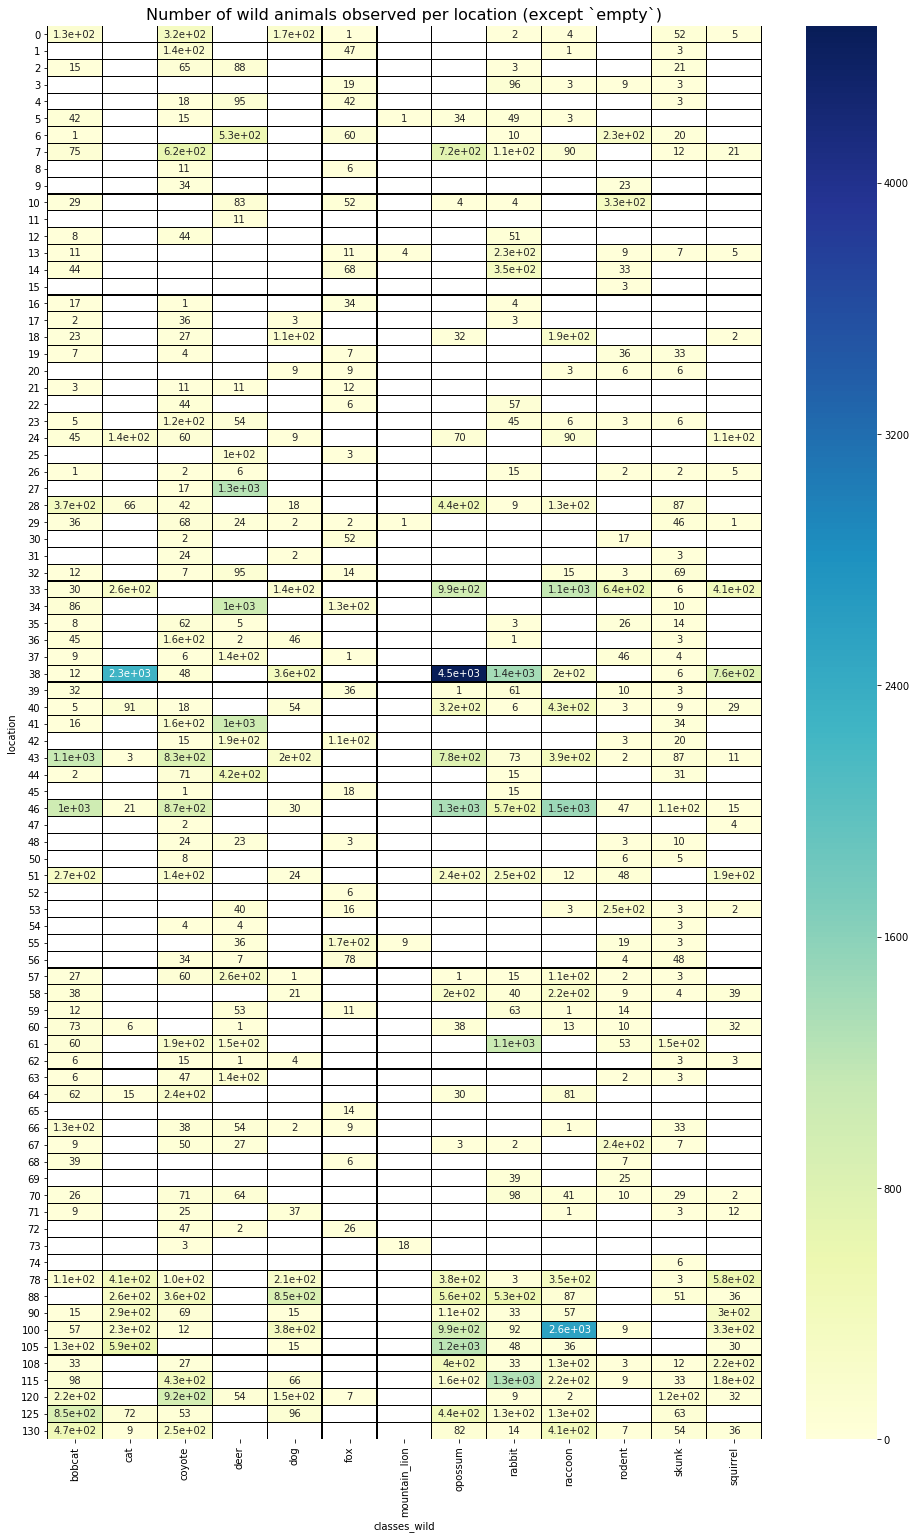

31159

In [20]:
fig, ax = plt.subplots(1,1,figsize=(16,26))
tmp = train_df[train_df['classes_wild'] != 'empty']
t = pd.DataFrame(tmp.groupby(['classes_wild', 'location'])['seq_id'].count().reset_index())
m = t.pivot(index='location', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per location (except `empty`)', size=16)
plt.show()
del t, tmp, m
gc.collect()

## Rights holder

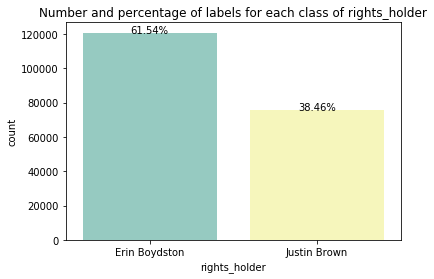

In [21]:
plot_classes('rights_holder', fs=3)

Only two rights holder are registered in `train_df` data.  

Let's check the rights holder and type of images taken by each.

## Rights holder and wild animals class


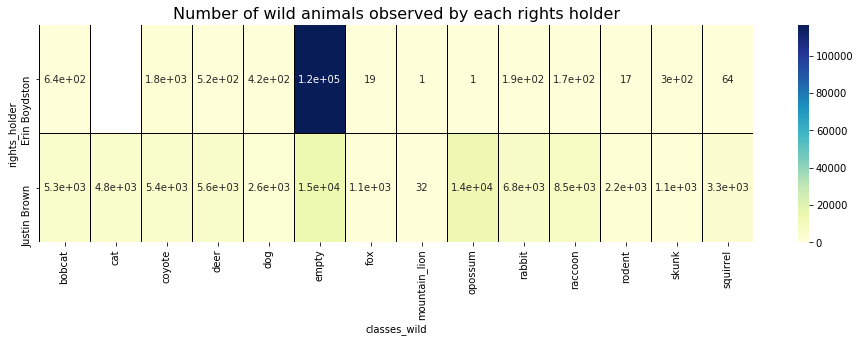

In [22]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
t = pd.DataFrame(train_df.groupby(['classes_wild', 'rights_holder'])['seq_id'].count().reset_index())
m = t.pivot(index='rights_holder', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed by each rights holder', size=16)
plt.show()

We remove the `empty` class to see better the other classes.

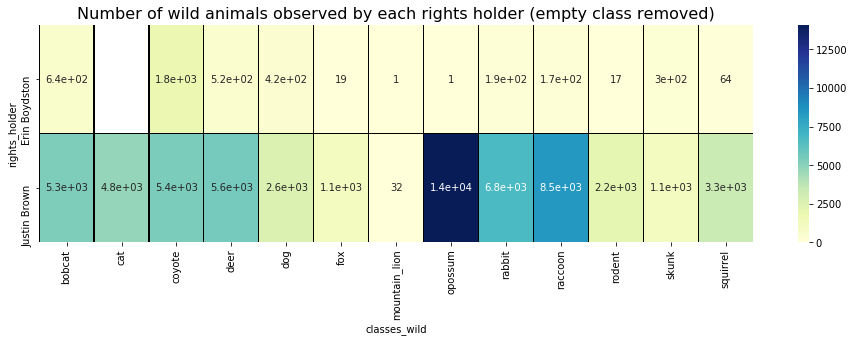

In [23]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
t = pd.DataFrame(train_df[~(train_df.classes_wild == 'empty')].groupby(['classes_wild', 'rights_holder'])['seq_id'].count().reset_index())
m = t.pivot(index='rights_holder', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed by each rights holder (empty class removed)', size=16)
plt.show()

## Extract date and time information

In [24]:
try:
    train_df['date_time'] = pd.to_datetime(train_df['date_captured'], errors='coerce')
    train_df["year"] = train_df['date_time'].dt.year
    train_df["month"] = train_df['date_time'].dt.month
    train_df["day"] = train_df['date_time'].dt.day
    train_df["hour"] = train_df['date_time'].dt.hour
    train_df["minute"] = train_df['date_time'].dt.minute
except Exception as ex:
    print("Exception:".format(ex))   

Let's check again the data.

In [25]:
train_df.head()

category_id        date_captured   ...    hour  minute
0           19  2011-05-13 23:43:18   ...    23.0    43.0
1           19  2012-03-17 03:48:44   ...     3.0    48.0
2            0  2014-05-11 11:56:46   ...    11.0    56.0
3            0  2013-10-06 02:00:00   ...     2.0     0.0
4            0  2011-07-12 13:11:16   ...    13.0    11.0

[5 rows x 18 columns]

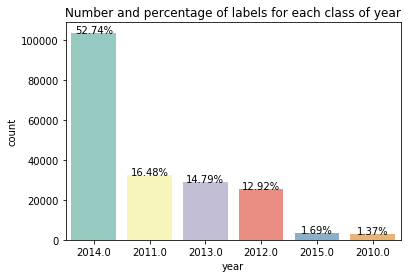

In [26]:
plot_classes('year', fs=3)

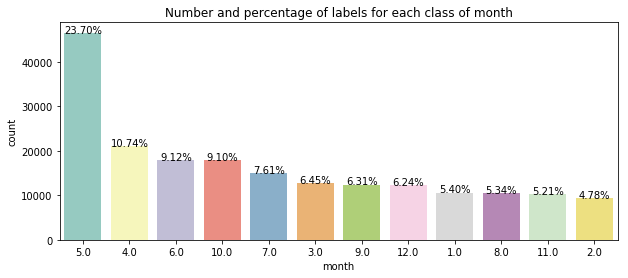

In [27]:
plot_classes('month', fs=5)

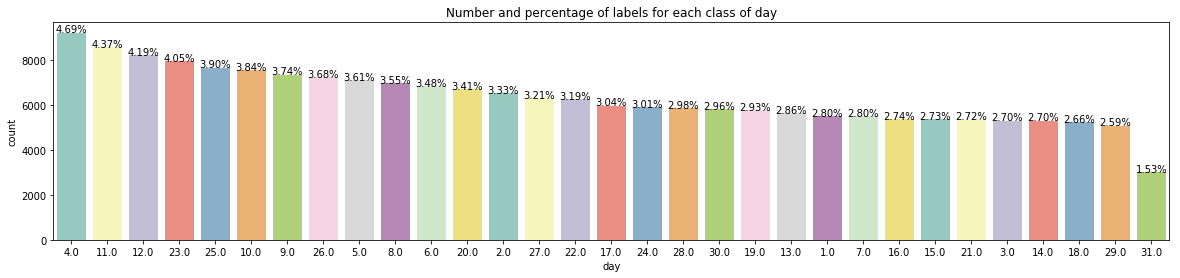

In [28]:
plot_classes('day', fs=10)

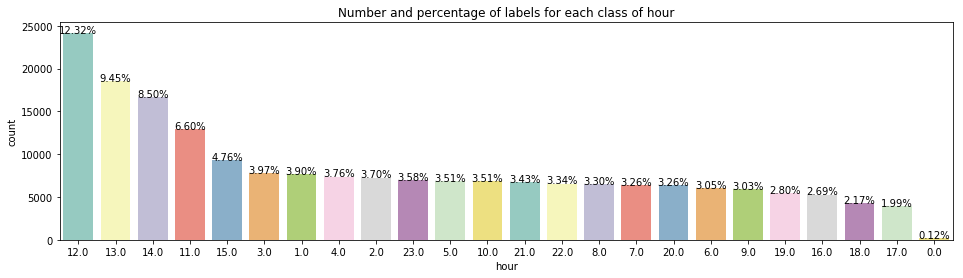

In [29]:
plot_classes('hour', fs=8)

## Classes and hours  

Let's show the number of wild animals observed at different hours.

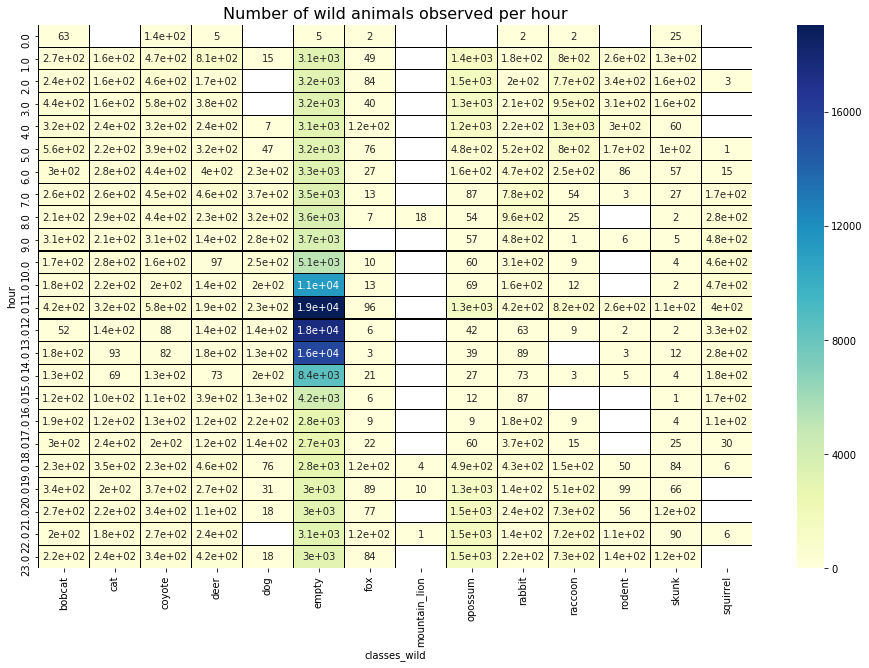

In [30]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
t = pd.DataFrame(train_df.groupby(['classes_wild', 'hour'])['seq_id'].count().reset_index())
m = t.pivot(index='hour', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per hour', size=16)
plt.show()

We remove `empty` class, which is observed mostly around noon, to see better the other classes distribution on hours.


## Classes and months

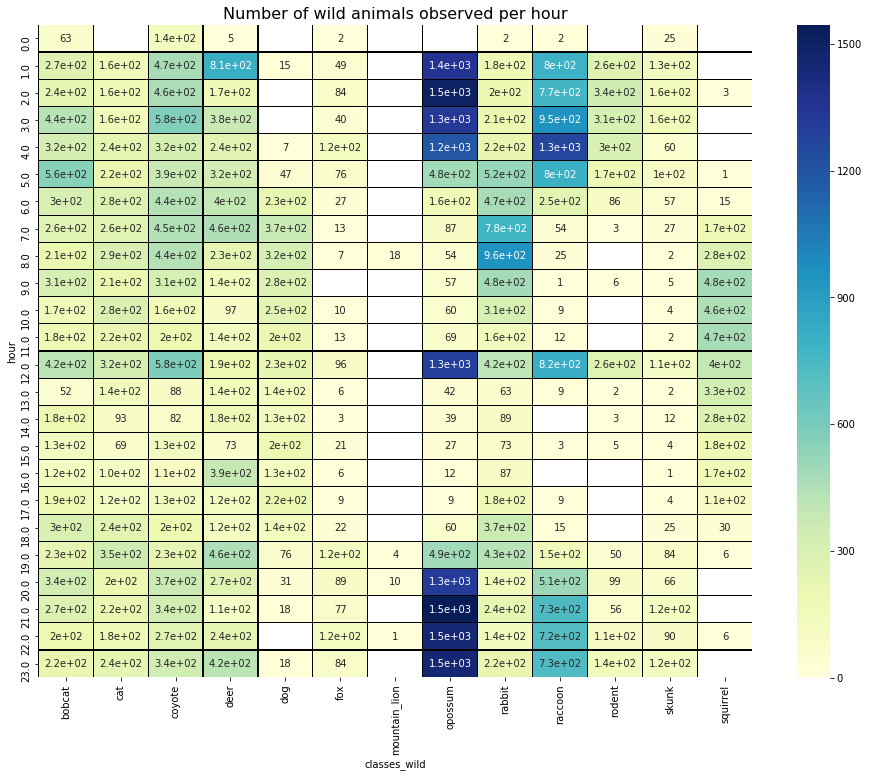

In [31]:
tmp = train_df[train_df['classes_wild'] != 'empty']
fig, ax = plt.subplots(1,1,figsize=(16,12))
t = pd.DataFrame(tmp.groupby(['classes_wild', 'hour'])['seq_id'].count().reset_index())
m = t.pivot(index='hour', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per hour', size=16)
plt.show()

We can observe that majority of racoons and opossums images are captured during night.  

Let's see in what month are each species images mostly captured.

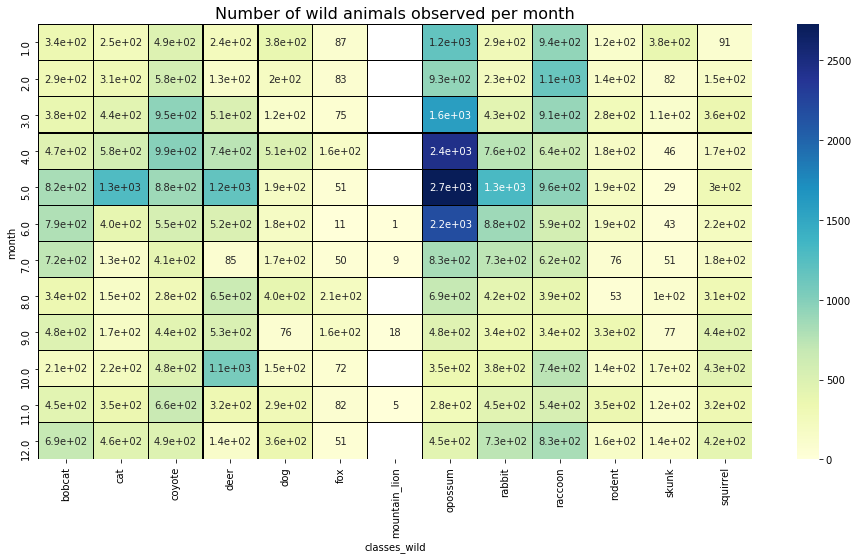

In [32]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
t = pd.DataFrame(tmp.groupby(['classes_wild', 'month'])['seq_id'].count().reset_index())
m = t.pivot(index='month', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per month', size=16)
plt.show()

All these visualizations suffers from one problem: the distribution of majority classes obscures the distribution of minority classes. We will try to create a heatmap for each species. Let's do this showing month and hour for each species, on a separate histogram.


## Classes per hour and month

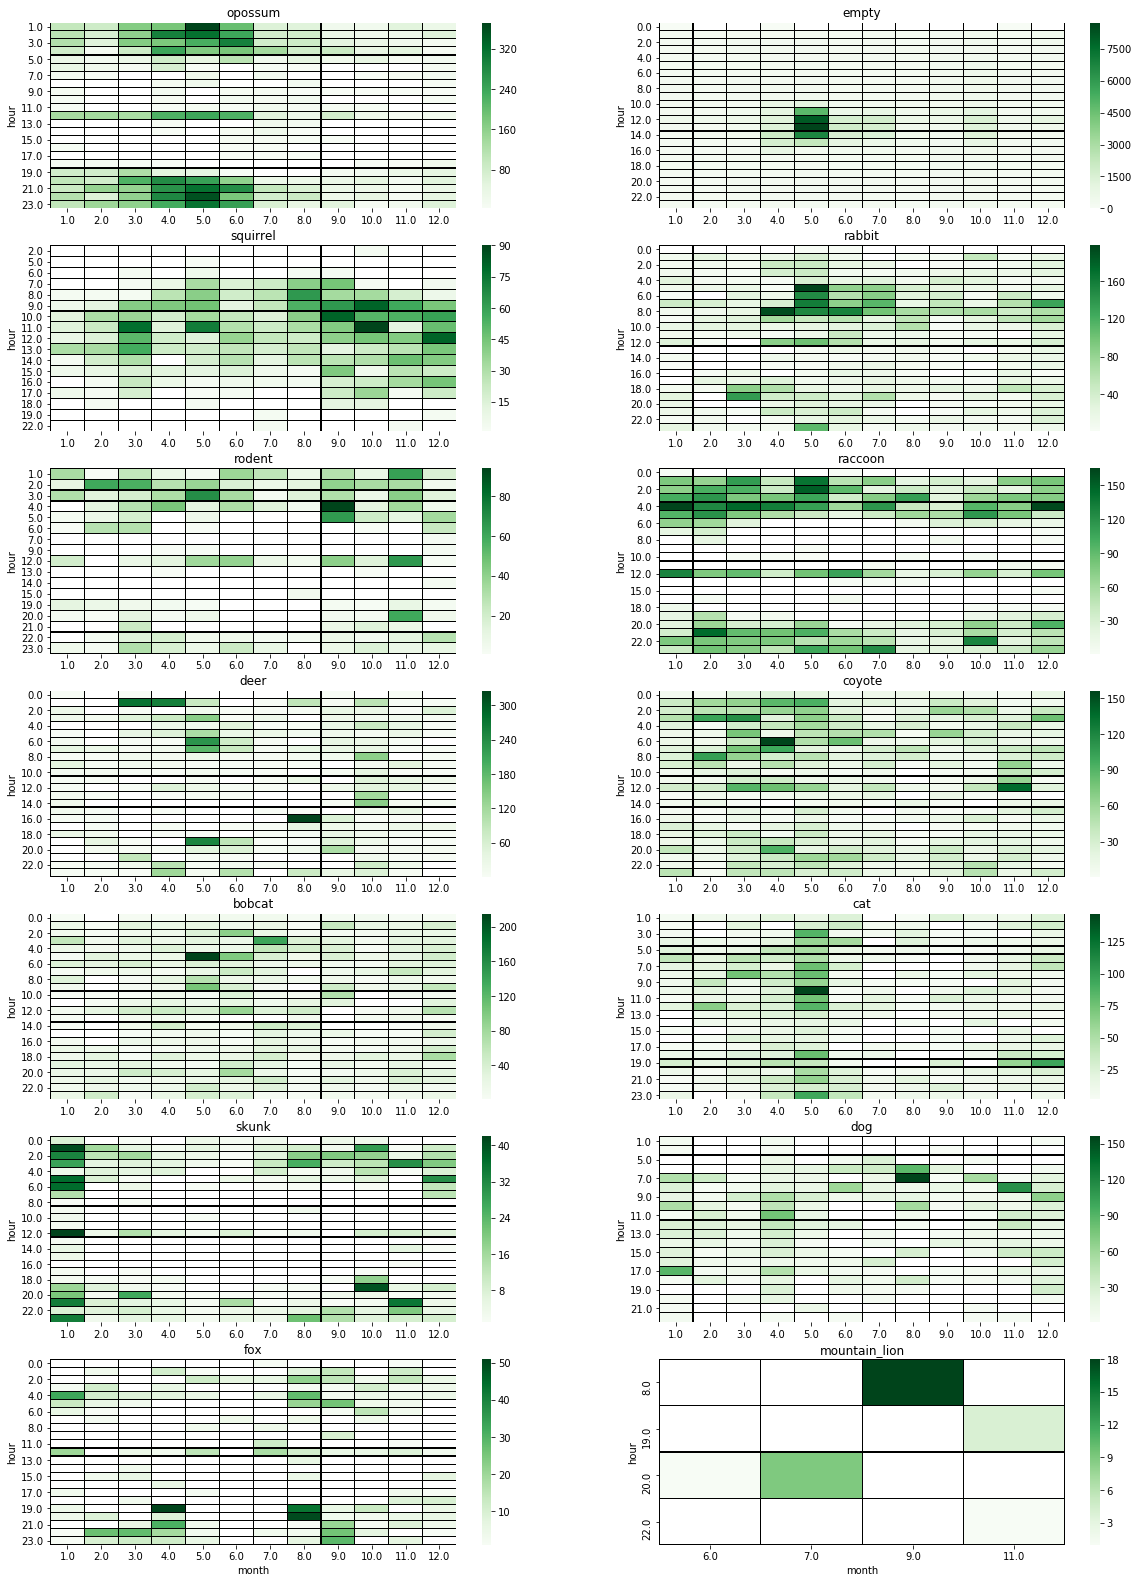

In [33]:
classes = train_df.classes_wild.unique()
fig, ax = plt.subplots(7,2,figsize=(20,28))
i = 0
for class_wild in classes:
    i = i + 1
    plt.subplot(7,2,i)
    tmp = train_df[train_df['classes_wild'] == class_wild]
    t = pd.DataFrame(tmp.groupby(['month', 'hour'])['seq_id'].count().reset_index())
    m = t.pivot(index='hour', columns='month', values='seq_id')
    s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=False, cmap="Greens")
    if(i<13):
        s.set_xlabel('')    
    s.set_title(class_wild, size=12)

plt.show()

## Classes per rights holder and month

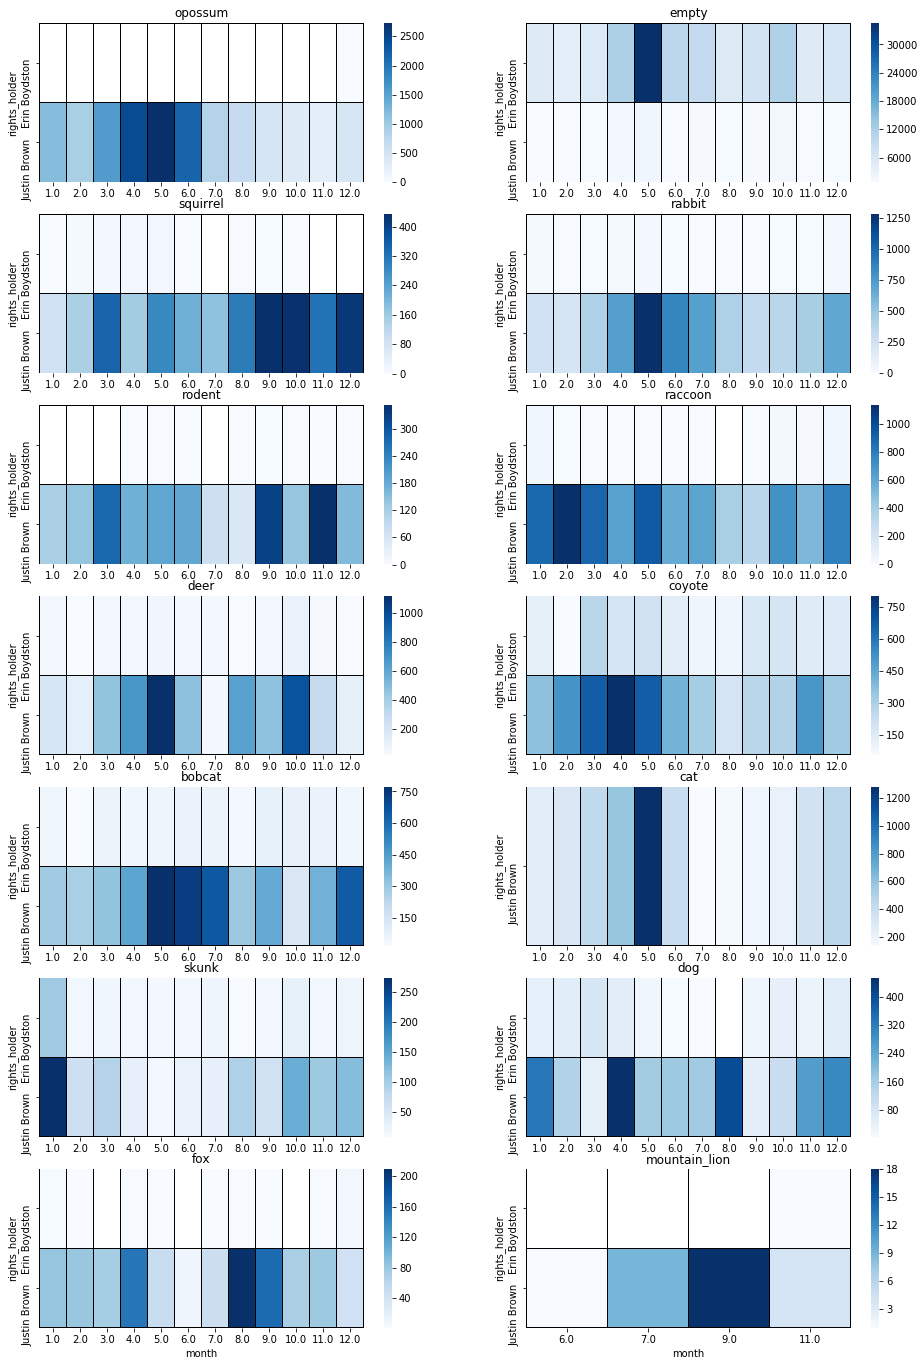

In [34]:
classes = train_df.classes_wild.unique()
fig, ax = plt.subplots(7,2,figsize=(16,24))
i = 0
for class_wild in classes:
    i = i + 1
    plt.subplot(7,2,i)
    tmp = train_df[train_df['classes_wild'] == class_wild]
    t = pd.DataFrame(tmp.groupby(['rights_holder', 'month'])['seq_id'].count().reset_index())
    m = t.pivot(index='rights_holder', columns='month', values='seq_id')
    s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=False, cmap="Blues")
    if(i<13):
        s.set_xlabel('')    
    s.set_title(class_wild, size=12)

plt.show()

## Train images samples   

Let's show a part of the images from train_df set.

In [35]:
def draw_category_images(var,cols=5):
    categories = (train_df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(3*cols,3*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = train_df[train_df[var]==cat].sample(cols)
        for j in range(0,cols):
            file=IMAGE_PATH + sample.iloc[j]['file_name']
            im = Image.open(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()

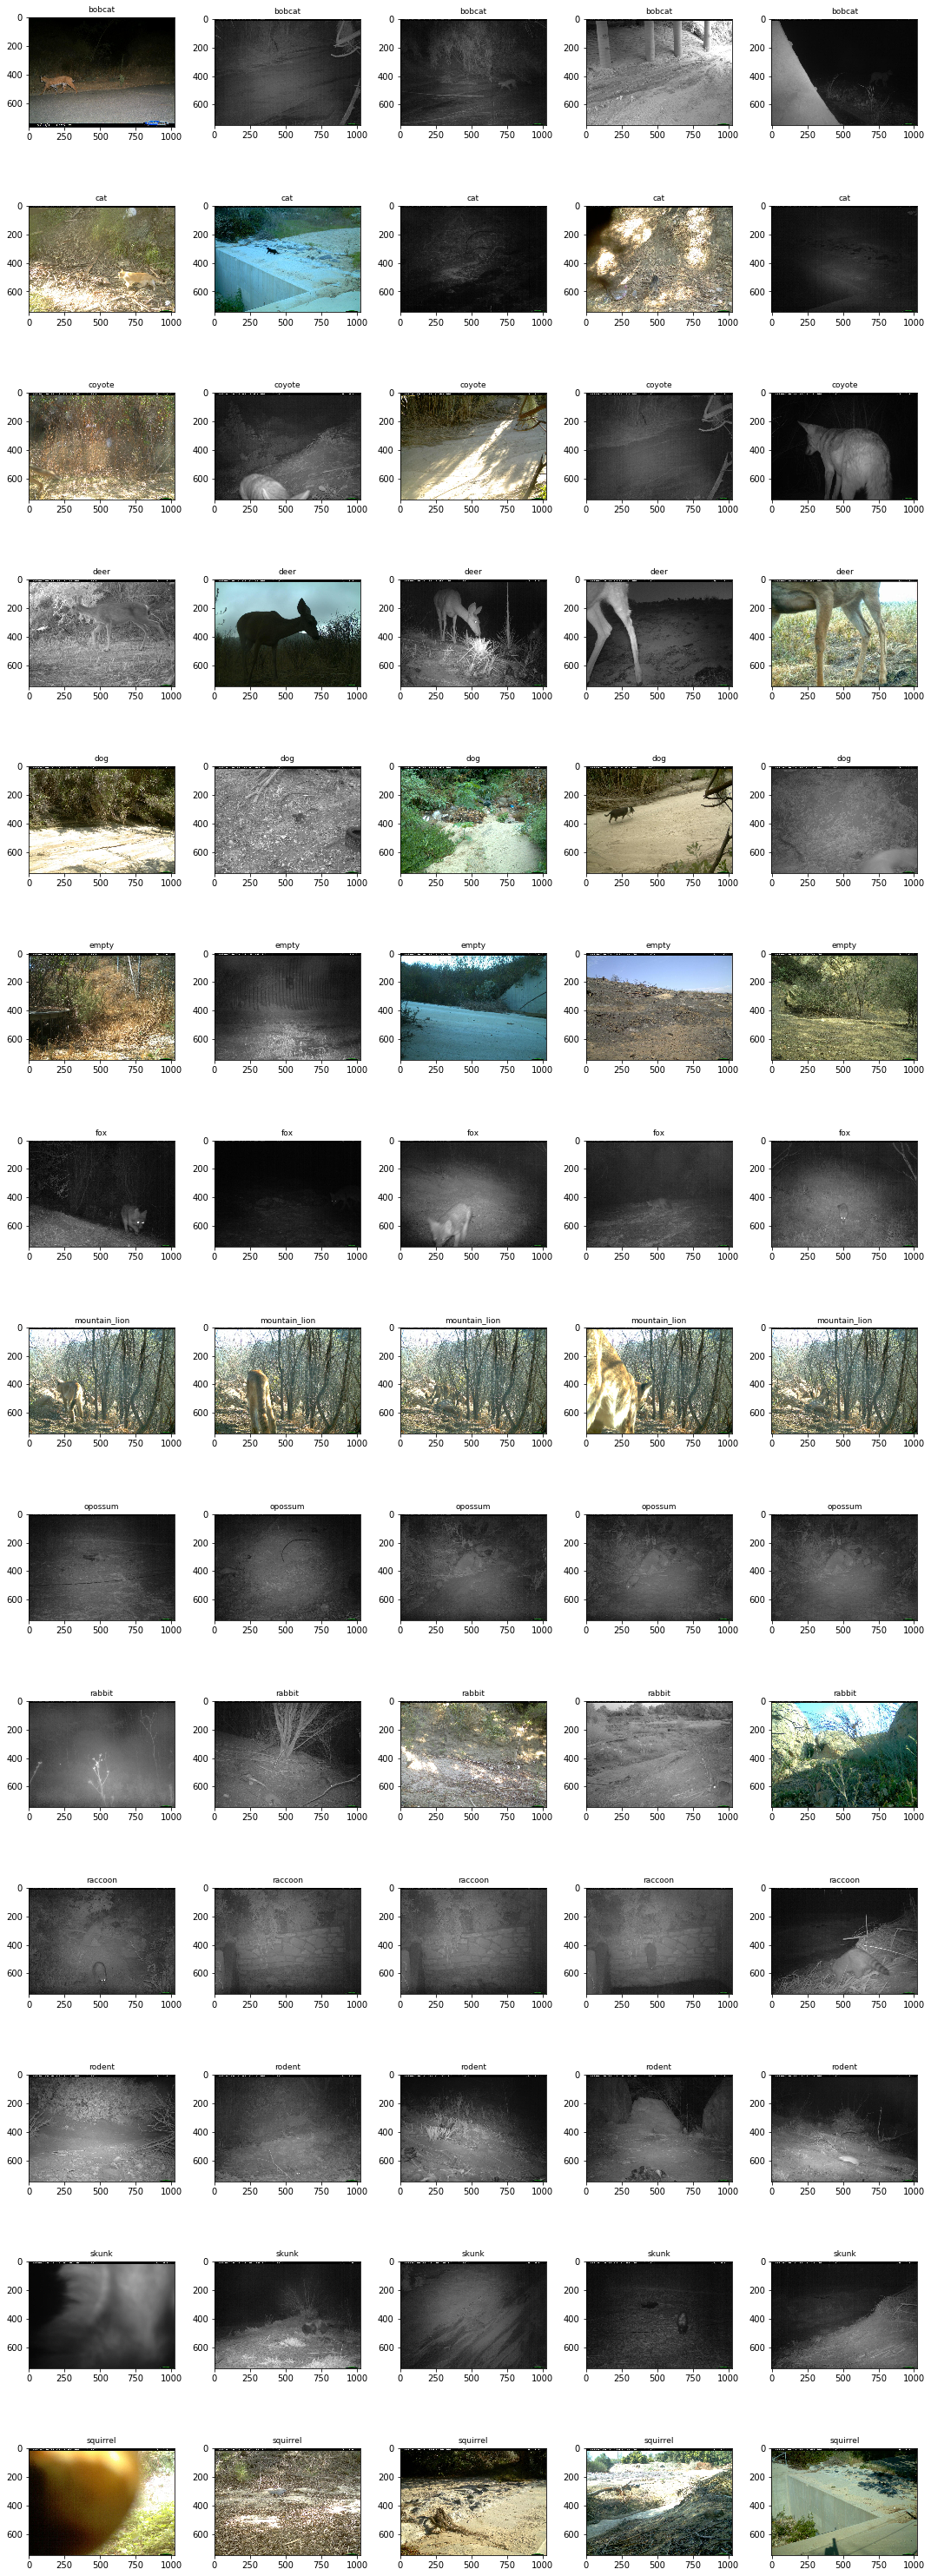

In [36]:
IMAGE_PATH = os.path.join(PATH,'train_images/')
draw_category_images('classes_wild')

## Test images samples

Let's also draw few test images samples.

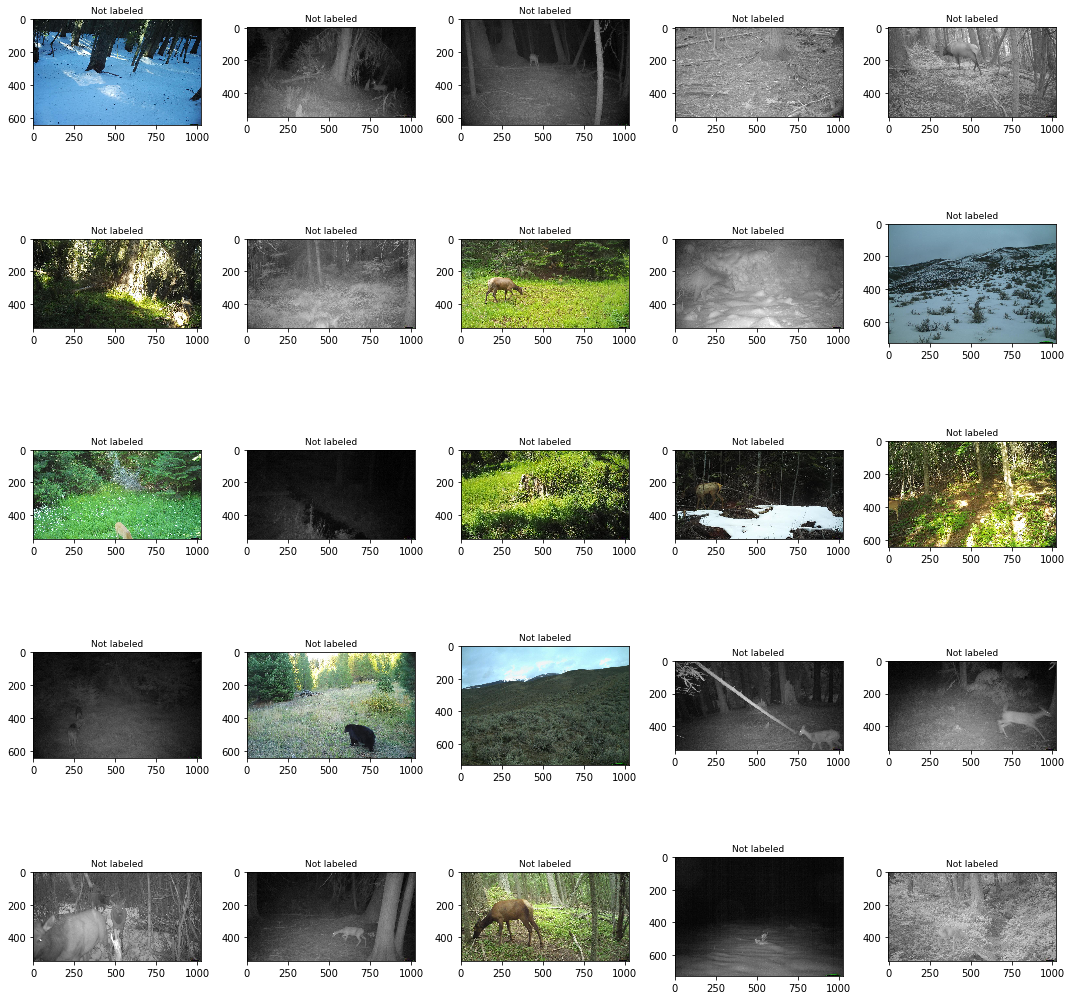

In [37]:
IMAGE_PATH = os.path.join(PATH,'test_images/')
f, ax = plt.subplots(nrows=5,ncols=5, figsize=(15,15))

for i in range(5):
    sample = test_df.sample(5)
    for j in range(5):
        file=IMAGE_PATH + sample.iloc[j]['file_name']
        im = Image.open(file)
        ax[i, j].imshow(im, resample=True)
        ax[i, j].set_title('Not labeled', fontsize=9)  
plt.tight_layout()
plt.show()


# <a id='4'>Model</a>  

Let's convert the compact 32x32 images to float and scale to 0 to 1.  
I used the <a href='#7'>References</a> [5] (credits should to go to this Kernel mostly), [6], [7], [8], [9].


## Scale the images

In [38]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

## Metric

In [39]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=14
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

f1_metrics = Metrics()

## Define the model   

I used the <a href='#7'>References</a> [5] (credits should to go to this Kernel mostly), [6], [7], [8], [9], [10] for creation of this model.


In [40]:
model_densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(32,32,3)
)

Instructions for updating:
Colocations handled automatically by placer.


We are using the number of images classes inferred before to init the **Dense** layer.

In [41]:
model = Sequential()
model.add(model_densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(cnt_classes_images, activation='softmax'))

In [42]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

A model is saved every training epoch if the validation error improved.

In [43]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

Let's check the resulting model.

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                14350     
Total params: 7,051,854
Trainable params: 6,968,206
Non-trainable params: 83,648
_________________________________________________________________


## Train the model

In [45]:
BATCH_SIZE = 64
EPOCHS = 35
VALID_SPLIT = 0.1
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, f1_metrics],
    validation_split=VALID_SPLIT
)

Instructions for updating:
Use tf.cast instead.
Train on 176669 samples, validate on 19630 samples
Epoch 1/35
176669/176669 [==============================] - 460s 3ms/step - loss: 0.6874 - acc: 0.7841 - val_loss: 0.5427 - val_acc: 0.8212

Epoch 00001: val_acc improved from -inf to 0.82119, saving model to model.h5
val_f1: 0.4375 — val_precision: 0.5072 — val_recall: 0.4139
Epoch 2/35
176669/176669 [==============================] - 428s 2ms/step - loss: 0.4890 - acc: 0.8384 - val_loss: 0.4998 - val_acc: 0.8380

Epoch 00002: val_acc improved from 0.82119 to 0.83795, saving model to model.h5
val_f1: 0.5099 — val_precision: 0.6047 — val_recall: 0.5046
Epoch 3/35
176669/176669 [==============================] - 430s 2ms/step - loss: 0.4107 - acc: 0.8624 - val_loss: 0.4027 - val_acc: 0.8667

Epoch 00003: val_acc improved from 0.83795 to 0.86673, saving model to model.h5
val_f1: 0.6407 — val_precision: 0.6910 — val_recall: 0.6277
Epoch 4/35
176669/176669 [==============================] - 4

## Validation

<Figure size 432x288 with 0 Axes>

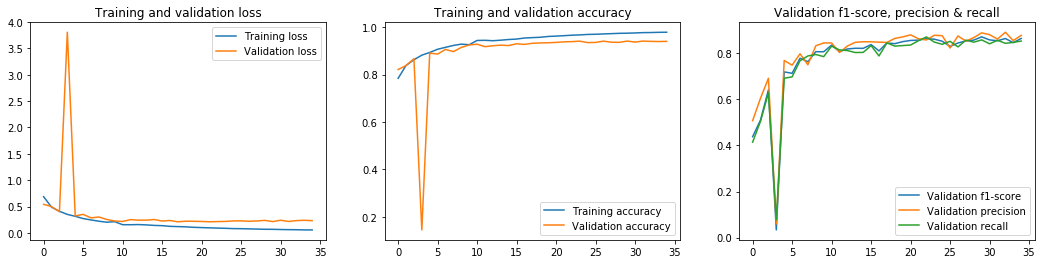

In [46]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)
h_df = pd.DataFrame(history.history)
h_df['val_f1'] = f1_metrics.val_f1s
h_df['val_precision'] = f1_metrics.val_precisions
h_df['val_recall'] = f1_metrics.val_recalls
epochs = range(len(h_df['val_f1']))
plt.figure()
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(epochs,h_df['loss'], label='Training loss')
ax[0].plot(epochs,h_df['val_loss'], label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].legend()
ax[1].plot(epochs,h_df['acc'],label='Training accuracy')
ax[1].plot(epochs,h_df['val_acc'], label='Validation accuracy')
ax[1].set_title('Training and validation accuracy')
ax[1].legend()
ax[2].plot(epochs,h_df['val_f1'],label='Validation f1-score')
ax[2].plot(epochs,h_df['val_precision'],label='Validation precision')
ax[2].plot(epochs,h_df['val_recall'],label='Validation recall')
ax[2].set_title('Validation f1-score, precision & recall')
ax[2].legend()
plt.show()

## Submission

First, we load the model and predict.

In [47]:
model.load_weights('model.h5')
#prepare prediction
y_test = model.predict(x_test)

![](http://)Then, we prepare the submission.

In [48]:
#submission
submission_df = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))
submission_df['Predicted'] = y_test.argmax(axis=1)

print(submission_df.shape)
submission_df.head(3)

(153730, 2)


Id  Predicted
0  b005e5b2-2c0b-11e9-bcad-06f10d5896c4          0
1  f2347cfe-2c11-11e9-bcad-06f10d5896c4          1
2  27cf8d26-2c0e-11e9-bcad-06f10d5896c4          0

We write the submission file.

In [49]:
submission_df.to_csv("submission.csv", index=False)

# <a id='5'>References</a>

[1] https://www.kaggle.com/gpreda/honey-bee-subspecies-classification   
[2] https://www.kaggle.com/gpreda/robots-need-help  
[3] https://www.kaggle.com/artgor/iwildcam-basic-eda  
[4] https://www.kaggle.com/c/iwildcam-2019-fgvc6/  
[5] https://www.kaggle.com/xhlulu/keras-cnn-starter-petfinder/  
[6] https://www.kaggle.com/xhlulu/reducing-image-sizes-to-32x32  
[7] https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2  
[8] https://www.kaggle.com/xhlulu/cnn-baseline-iwildcam-2019  
[9] https://www.kaggle.com/xhlulu/densenet-transfer-learning-iwildcam-2019/  
[10] https://www.kaggle.com/gpreda/cats-or-dogs-using-cnn-with-transfer-learning
